# Zillow Time Series

Authors: Matthew Reinhart, Jerry Vasquez, Wahaj Dahar

# Business Objective

This project posits that we are consultants for a real estate company. We have been asked what are the five best zipcodes in the Metropolitan are of Phoenix to invest in for this company. We decided to look at growth to determine which should be considered the five best.

# Data

This project uses data from the [Zillow Research Page](https://www.zillow.com/research/data/) database. Which contains approximately 15,000 lines with basic information such as city, state, county, size rank from April 1996 - April 2018. We focused in on Zipcodes from the Phoenix area over the last 10 years.

# Methodology

Instead of using the given value column to model which zipcodes would be best we created a growth column in order to see how they grow on a month to month basis.
After creating that column we limited the data to the top 10 zipcodes in the Phoenix metropolitan area and from there did extensive modeling to find the five zipcodes that would return the highest growth in the area.

# Data Cleaning

The files we downloaded from Zillow include data from 1996 to 2018. The dataset after some quick reformating had 3744704 rows and 9 columns. This was including all data nationally though and we would shrink the data so that it only includes Arizona data. 

Once we shrunk it down to Arizona data and cleaned that we were left with 58775 rows and 4 columns. However the most important aspect is the number of unique zipcodes and that was 230. From there we focused in even further now looking at the best metropolitan area in Arizona which we showed to be Phoenix. Then from there narrowed it down to 10 Zipcodes to analyze. 

Once we have a target column, we can create a dataframe with full seasons worth of games with a target column, and train our model on it.

In [66]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [67]:
# import helper functions
from time_series_functions import *

In [68]:
#Read the data into notebook
df=pd.read_csv('zillow_data.csv')

In [69]:
#initial look at data
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


The first thing to be noticed is that the dates are all seperate columns here, this is quite curious and must be fixed, in order to do so we will call the melt function from our .py file

In [70]:
df=melt_data2(df)

In [71]:
#Take a look at new data
df.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


Great, now the time is one column, this will make our job much easier, now lets make time the index

In [72]:
df.set_index('time',inplace=True)

In [73]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [74]:
#Look at new df
df.head()

,RegionName,State,Metro,value
time,,,,
1996-04-01,60657,IL,Chicago,334200.0
1996-04-01,75070,TX,Dallas-Fort Worth,235700.0
1996-04-01,77494,TX,Houston,210400.0
1996-04-01,60614,IL,Chicago,498100.0
1996-04-01,79936,TX,El Paso,77300.0


In [75]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

# Data Exploration

## Create a new Dataframe that only contains Arizona Data

In [105]:
Arizona_df= df[(df['State'] == 'AZ')]

In [106]:
#Take only more recent years(post crisis)
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [107]:
#Find number of unique zipcodes in Arizona_df
print('Number of Zipcodes in Arizona_df:', Arizona_recent_yrs['Zipcode'].nunique())

Number of Zipcodes in Arizona_df: 230


In [78]:
# find which metro area to focus on
metro_group = Arizona_df.groupby('Metro')
metro_group = metro_group.value.mean()
metro_group = metro_group.sort_values(ascending=False).head(10)

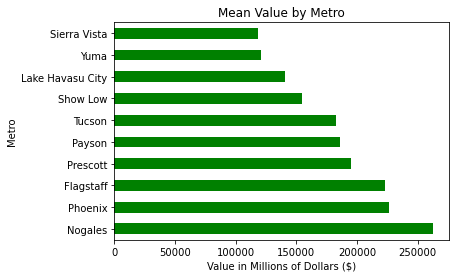

In [79]:
metro_group.plot.barh(color='green')
plt.title('Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

Nogales appears to be the highest one on this chart but lets look at the first three further

In [108]:
Nogales_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Nogales')]
len(Nogales_data.Zipcode.unique())

2

In [109]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]
len(Phoenix_data.Zipcode.unique())

126

In [110]:
Flag_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Flagstaff')]
len(Flag_data.Zipcode.unique())

6

Based on the number of zipcodes we have for each, we will limit the search to the Metro area of Phoenix

In [111]:
# Look at dataset
Phoenix_data.head()

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
2009-01-01,85251,AZ,Phoenix,252100.0


In [112]:
#Drop no longer needed columns
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

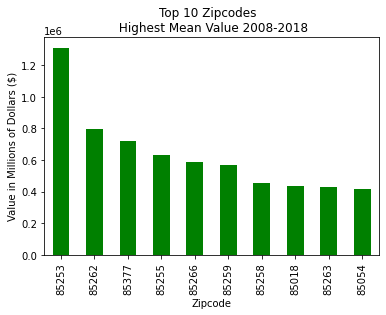

In [114]:
phx_zipcode_grp = Phoenix_data.groupby('Zipcode')
mean_value = phx_zipcode_grp.value.mean()
mean_value = mean_value.sort_values(ascending=False).head(10)
mean_value.plot.bar(color='green')
plt.title('Top 10 Zipcodes  \n Highest Mean Value 2008-2018')
plt.ylabel('Value in Millions of Dollars ($)')
plt.show();

In [158]:
# Take the top ten zipcodes
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

# Modeling

We went through and modeled each of these zipcodes and that information can be found in the Final Notebooks folder of this repository. In this notebook I will walk through one of the zipcodes however if you would like to see any of the others feel free to examine that folder.

Here we will go through the process for 85377:

In [188]:
#Get the zipcode alone
zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==85377]

In [189]:
#Drop the zipcode column
zip_zipcode.drop(['Zipcode'],axis=1,inplace=True)

zip_zipcode

,value
time,
2009-01-01,717600.0
2009-02-01,707000.0
2009-03-01,695400.0
2009-04-01,682100.0
2009-05-01,669000.0
...,...
2017-12-01,865500.0
2018-01-01,864700.0
2018-02-01,863200.0


In [190]:
len(zip_zipcode)

112

These next cells will create the growth column

In [191]:
resampled_shift_1 = zip_zipcode[['value']].shift(1)
resampled_shift_1.bfill(inplace=True)

In [192]:
zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
zip_zipcode['growth']= abs(zip_zipcode['growth'])

In [193]:
#We no longer need the value column so we may drop that
zip_zipcode.drop('value',axis=1,inplace=True)

In [194]:
#Here is what the dataframe now looks like
len(zip_zipcode)

112

In [195]:
# Check stationarity using function from .py file
stationarity_check(zip_zipcode)


Results of Dickey-Fuller Test: 

Test Statistic                -5.784114e+00
p-value                        5.045944e-07
#Lags Used                     1.000000e+00
Number of Observations Used    1.100000e+02
Critical Value (1%)           -3.491245e+00
Critical Value (5%)           -2.888195e+00
Critical Value (10%)          -2.580988e+00
dtype: float64


This data is already very stationary, in other cases we needed to take the log or difference the data to get a p-value that low!

In [196]:
#Drop the first row
zip_zipcode=zip_zipcode[1:]

In [197]:
len(zip_zipcode)

111

In [198]:
len(zip_zipcode)

111

There are some zipcodes that require further work to be made stationary but this p-value is already low enough

In [199]:
cutoff = round(zip_zipcode.shape[0]*0.8)
cutoff

89

In [200]:
# Define train and test sets according to the index found above
train = zip_zipcode[:cutoff]

test = zip_zipcode[cutoff:]

In [201]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] [33 34 35 36 37 38 39 40 41 42 43 44 45 46]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [47 48 49 50 51 52 53 54 55 56 57 58 59 60]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60] [61 62 63 64 65 66 67 68 69 70 71 72 73 74]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74] [75 76 77 78 79 80 81 82 83 84 85 86 87 88]


In [202]:
#Create Baseline
baseline = train.shift(1)
baseline.dropna(inplace=True)

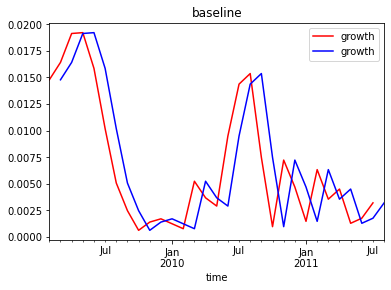

In [203]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [204]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

0.004163555753781438

In [205]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 4.549330094222553e-05,
 so we can safely assume that the differenced data is stationary.


In [206]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

2009-02-01    0.000000
2009-03-01    0.014771
2009-04-01    0.016457
2009-05-01    0.019209
2009-06-01    0.019208
                ...   
2016-02-01    0.004438
2016-03-01    0.005789
2016-04-01    0.004305
2016-05-01    0.003691
2016-06-01    0.005982
Freq: MS, Name: predicted_mean, Length: 89, dtype: float64

In [207]:
sari_mod =SARIMAX(train,
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [208]:
train_with_ind = train.reset_index()

In [209]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.011725697979610192
0.005390845562608503
0.008600295233195108
0.008520336425441878
0.005943141540462915


In [210]:
sari_mod = SARIMAX(zip_zipcode,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [211]:
#Steps can be changed to further or lesson forecast
forecast = sari_mod.forecast(steps=75)

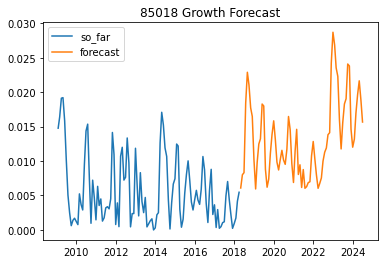

In [212]:
fig, ax = plt.subplots()
ax.plot(zip_zipcode, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('85018 Growth Forecast')

plt.legend();

In [213]:
forecast.mean()

0.013297886468824151

# Conclusion

After iterating through each zipcode and judging them based on the mean growth of the SARIMAX Forecast we found the five best zipcodes to invest in were: 85258 with a forecasted growth rate of 148.97% 85018 with a forecasted growth rate of 7.65% 85377 with a forecasted growth rate of 1.33% 85262 with a forecasted growth rate of 1.06% 85263 with a forecasted growth rate of .25%

In conclusion The five Zipcodes we recommend above are the ones we would suggest you focus on in the Phoenix are and specifically those first two where there are more significant results.

The results of our time-series models were pretty encouraging based on the time frame we had to work on this project. We were able to make the data workable and build useable models with significant results.

If we did have more time we would have liked to look at the whole state of Arizona however we did not have time for that here so in the future we may revisit and analyze further.